<a href="https://colab.research.google.com/github/nehaa56789/Quantum-kmeans-clustering/blob/main/AI_DA3_iterations_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
!pip install qiskit joblib

In [30]:
pip install qiskit qiskit-aer

In [31]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import silhouette_score, davies_bouldin_score
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from joblib import Parallel, delayed
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [32]:
# Load dataset (Google Colab: upload interface; Kaggle: adjust filepath)
def load_dataset_kaggle():
    # Adjust path to Kaggle dataset here, e.g.:
    return pd.read_csv('/kaggle/input/atharvaingle-crop-recommendation-dataset/Crop_recommendation.csv')

def load_dataset_colab():
    from google.colab import files
    uploaded = files.upload()
    filename = next(iter(uploaded))
    return pd.read_csv(filename)

# Choose environment here:
USE_KAGGLE = False

if USE_KAGGLE:
    df = load_dataset_kaggle()
else:
    df = load_dataset_colab()

print("Original dataset size:", len(df))

Saving Crop_recommendation.csv to Crop_recommendation (2).csv
Original dataset size: 2200


In [33]:
# Select features
features = ['N','P','K','temperature','humidity','ph','rainfall']
X = df[features].values

# Standardize and normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_norm = normalize(X_scaled, norm='l2')

In [47]:
# Enlarge dataset by bootstrap resampling with two seeds for diversity
synthetic_size = 8000
X_synthetic = np.vstack([
    resample(X_norm, n_samples=synthetic_size//2, random_state=42),
    resample(X_norm, n_samples=synthetic_size//2, random_state=24)
])
print("Expanded dataset size:", X_synthetic.shape[0])

# Create a DataFrame
df_expanded = pd.DataFrame(X_synthetic, columns=features)

# Save to a CSV file
df_expanded.to_csv('expanded_dataset.csv', index=False)

Expanded dataset size: 8000


In [35]:
# --- Quantum K-Means clustering components ---

def amplitude_encode(x):
    norm = np.linalg.norm(x)
    return x / norm if norm != 0 else x

def make_qc_from_vector(vec):
    n_qubits = int(np.ceil(np.log2(len(vec))))
    state = np.zeros(2**n_qubits)
    state[:len(vec)] = amplitude_encode(vec)
    norm = np.linalg.norm(state)
    state = state / norm
    qc = QuantumCircuit(n_qubits)
    qc.initialize(state, list(range(n_qubits)))
    return qc

In [36]:
def swap_test_similarity(vec1, vec2, shots=512):
    qc1 = make_qc_from_vector(vec1)
    qc2 = make_qc_from_vector(vec2)

    n = qc1.num_qubits
    qc = QuantumCircuit(n*2+1, 1)

    qc.compose(qc1, qubits=range(1, n+1), inplace=True)
    qc.compose(qc2, qubits=range(n+1, 2*n+1), inplace=True)

    qc.h(0)
    for i in range(n):
        qc.cswap(0, i+1, i+1+n)
    qc.h(0)
    qc.measure(0, 0)

    backend = Aer.get_backend('qasm_simulator')
    job = backend.run(qc, shots=shots)
    result = job.result()
    counts = result.get_counts()

    prob0 = counts.get('0', 0) / shots
    sim = max(0.0, 2*prob0 - 1)
    return sim

In [37]:
def compute_similarities_all(X, centroids, shots=512, n_jobs=-1):
    def sim_func(x):
        return [swap_test_similarity(x, c, shots=shots) for c in centroids]
    sims = Parallel(n_jobs=n_jobs)(delayed(sim_func)(x) for x in X)
    return np.array(sims)

def kmeans_plus_plus_init(X, k):
    np.random.seed(42)
    centroids = []
    centroids.append(X[np.random.randint(len(X))])
    for _ in range(1, k):
        dists = np.array([min([np.linalg.norm(x - c)**2 for c in centroids]) for x in X])
        probs = dists / dists.sum()
        cumulative_probs = np.cumsum(probs)
        r = np.random.rand()
        idx = np.searchsorted(cumulative_probs, r)
        centroids.append(X[idx])
    return np.array(centroids)

In [38]:
def quantum_kmeans(X, k=7, max_iters=10, tol=1e-4, shots=512):
    centroids = kmeans_plus_plus_init(X, k)
    for iter in range(max_iters):
        sims = compute_similarities_all(X, centroids, shots=shots)
        dists = np.sqrt(1 - sims)
        labels = np.argmin(dists, axis=1)

        new_centroids = []
        for cluster_idx in range(k):
            cluster_points = X[labels == cluster_idx]
            if len(cluster_points) > 0:
                new_centroids.append(np.mean(cluster_points, axis=0))
            else:
                new_centroids.append(X[np.random.randint(len(X))])
        new_centroids = np.array(new_centroids)

        centroid_shift = np.linalg.norm(new_centroids - centroids)
        print(f"Iteration {iter+1}: centroid shift = {centroid_shift:.6f}")
        if centroid_shift < tol:
            print("Converged.")
            break
        centroids = new_centroids

    sims = compute_similarities_all(X, centroids, shots=shots)
    dists = np.sqrt(1 - sims)
    labels = np.argmin(dists, axis=1)
    return labels

In [43]:
labels = quantum_kmeans(X_synthetic, k=7, max_iters=5, shots=512)
print("First 30 cluster labels:", labels[:30])

print("Silhouette Score:", silhouette_score(X_synthetic, labels))
print("Davies-Bouldin Index:", davies_bouldin_score(X_synthetic, labels))

Iteration 1: centroid shift = 1.786012
Iteration 2: centroid shift = 0.878309
Iteration 3: centroid shift = 0.702594
Iteration 4: centroid shift = 0.710624
Iteration 5: centroid shift = 0.719183
First 30 cluster labels: [6 2 3 5 5 1 0 2 3 0 2 0 4 6 2 2 4 3 3 6 6 3 5 1 4 4 5 3 4 2]
Silhouette Score: 0.24144253367700066
Davies-Bouldin Index: 1.9023482038553496


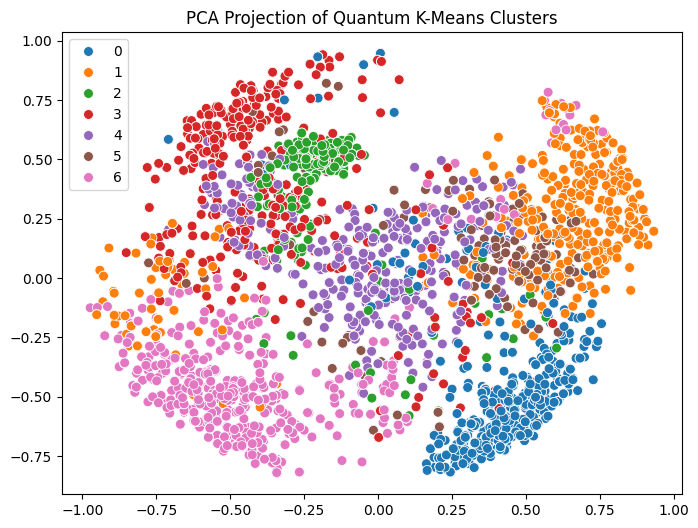

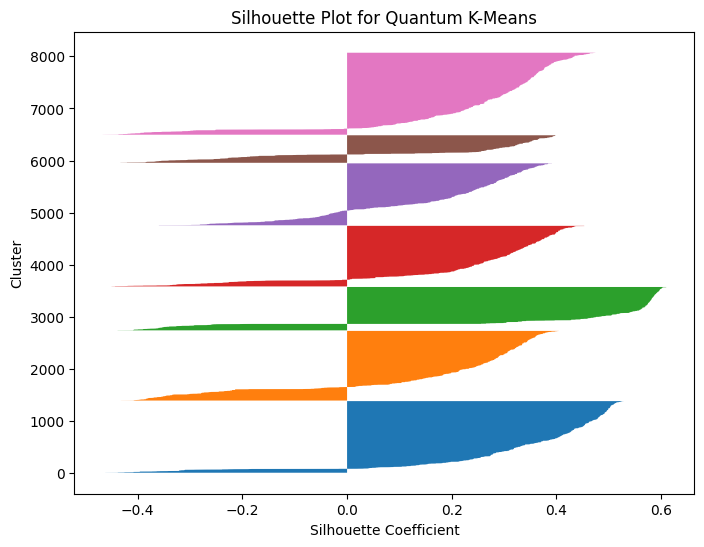

Davies-Bouldin Index (Quantum): 1.9023
Calinski-Harabasz Index (Quantum): 947.9222


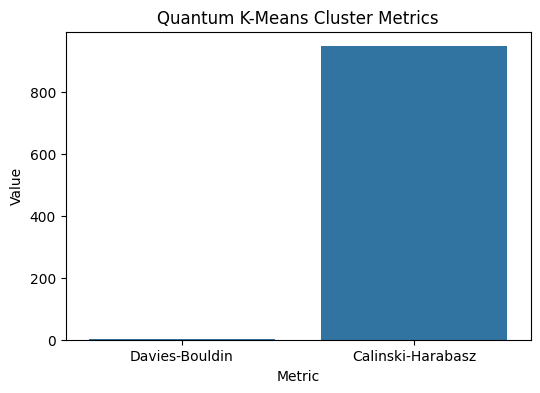

/tmp/ipython-input-4052698244.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='tab10')


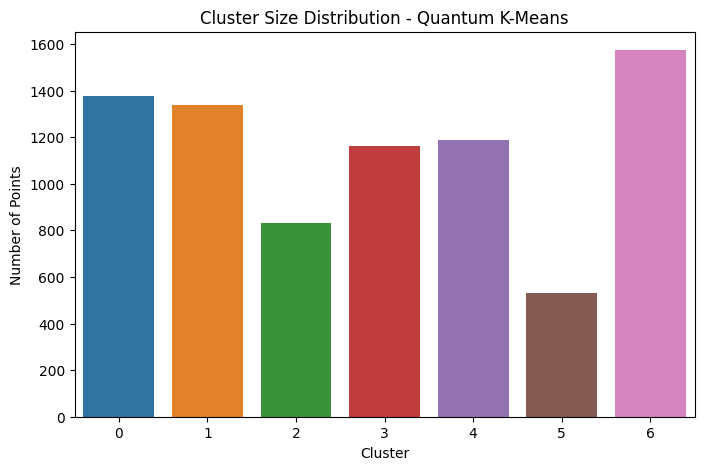

In [46]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import silhouette_samples, davies_bouldin_score, calinski_harabasz_score
import pandas as pd

# Create DataFrame for visualization
df_viz = pd.DataFrame(X_synthetic)
df_viz['Quantum_Cluster'] = labels

# PCA transform
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_synthetic)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df_viz['Quantum_Cluster'], palette='tab10', s=50, legend='full')
plt.title("PCA Projection of Quantum K-Means Clusters")
plt.legend()
plt.show()

# Silhouette plot
sil_samples = silhouette_samples(X_synthetic, df_viz['Quantum_Cluster'])
y_lower = 10
k = len(np.unique(labels))

plt.figure(figsize=(8,6))
for i in range(k):
    ith_cluster_silhouette = sil_samples[df_viz['Quantum_Cluster'] == i]
    ith_cluster_silhouette.sort()
    plt.fill_betweenx(np.arange(y_lower, y_lower + len(ith_cluster_silhouette)),
                      0, ith_cluster_silhouette)
    y_lower += len(ith_cluster_silhouette) + 10

plt.xlabel("Silhouette Coefficient")
plt.ylabel("Cluster")
plt.title("Silhouette Plot for Quantum K-Means")
plt.show()

# Calculate and display Davies-Bouldin and Calinski-Harabasz indices
dbi = davies_bouldin_score(X_synthetic, df_viz['Quantum_Cluster'])
chi = calinski_harabasz_score(X_synthetic, df_viz['Quantum_Cluster'])
print(f"Davies-Bouldin Index (Quantum): {dbi:.4f}")
print(f"Calinski-Harabasz Index (Quantum): {chi:.4f}")

# Bar plot for metrics
metrics_df = pd.DataFrame({'Metric': ['Davies-Bouldin', 'Calinski-Harabasz'], 'Value': [dbi, chi]})
plt.figure(figsize=(6,4))
sns.barplot(x='Metric', y='Value', data=metrics_df)
plt.title('Quantum K-Means Cluster Metrics')
plt.show()

# Cluster size distribution plot
cluster_counts = df_viz['Quantum_Cluster'].value_counts().sort_index()
plt.figure(figsize=(8,5))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='tab10')
plt.xlabel('Cluster')
plt.ylabel('Number of Points')
plt.title('Cluster Size Distribution - Quantum K-Means')
plt.show()